# Faster RCNN with torchvision

This Jupyter notebook provides a minimal working example of Faster R-CNN in PyTorch. Faster R-CNN is a two-stage object detection model that first generates candidate object regions using a region proposal network (RPN), and then classifies and regresses the candidate object regions using a Fast R-CNN detector.

The notebook is organized as follows:

1. **Introduction:** This section provides a brief overview of Faster R-CNN and its architecture.
2. **Data:** This section loads the CPPE-5 dataset, which is a popular object detection dataset.
3. **Model:** This section defines the Faster R-CNN model. The model consists of a ResNet-50 backbone, an RPN, and a Fast R-CNN detector.
4. **Training:** This section trains the Faster R-CNN model on the CPPE-5 dataset.
5. **Evaluation:** This section evaluates the trained Faster R-CNN model on the dataset.

To run the notebook, please install PyTorch, albumentations, HF transformers and the torchvision package. Once you have installed them, you can run the notebook by clicking the "Run" button in the top toolbar.

## Introduction

Faster R-CNN is a two-stage object detection model that first generates candidate object regions using a region proposal network (RPN), and then classifies and regresses the candidate object regions using a Fast R-CNN detector.

The FasterRCNN model consists of three main components:

- Backbone network: The backbone network is a convolutional neural network (CNN) that is used to extract features from the input image.
- Region proposal network (RPN): The RPN generates candidate object regions by sliding a window over the input image and predicting whether each window contains an object.
- Fast R-CNN detector: The Fast R-CNN detector classifies and regresses the candidate object regions generated by the RPN.
- Transformer which performs are:
  - input normalization (mean subtraction and std division)
  - input / target resizing to match min_size / max_size

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# The following code shows a simplified example of a Faster R-CNN model's forward method:

def forward(images):
    normalized = transform.postprocess(images.tensors)
    features = backbone(normalized)
    proposals, proposal_losses = rpn(images, features)
    detections, detector_losses = rcnn_detector(features, proposals, images.image_sizes)
    detections = transform.postprocess(detections, images.image_sizes, original_image_sizes)

## Data
Let us load the CPPE-5 dataset, which is a new challenging dataset with the goal to allow the study of subordinate categorization of medical personal protective equipments, which is not possible with other popular data sets that focus on broad level categories.

In [2]:
#!pip install datasets -q
#!pip install albumentations -q
#!pip install transformers -q

import torch
import torch.nn as nn
import transformers

from datasets import load_dataset
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import albumentations
from albumentations import pytorch
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw

dataset = load_dataset("cppe-5")
example = dataset['train'][0]
example

Found cached dataset cppe-5 (/archive/turganbay/.huggingface/cppe-5/default/1.0.0/dd60c7c8210a67663b06108fb9e23c70acb98e2d3a4f3636f429509b19b74989)


  0%|          | 0/2 [00:00<?, ?it/s]

{'image_id': 15,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=943x663>,
 'width': 943,
 'height': 663,
 'objects': {'id': [114, 115, 116, 117],
  'area': [3796, 1596, 152768, 81002],
  'bbox': [[302.0, 109.0, 73.0, 52.0],
   [810.0, 100.0, 57.0, 28.0],
   [160.0, 31.0, 248.0, 616.0],
   [741.0, 68.0, 202.0, 401.0]],
  'category': [4, 4, 0, 0]}}

In [3]:
def process_boxes(boxes):
    new_boxes = []
    for box in boxes:
        xmin = box[0]
        xmax = xmin + box[2]
        ymin = box[1]
        ymax = ymin + box[3]
        new_boxes.append([xmin, ymin, xmax, ymax])

    boxes = torch.tensor(new_boxes, dtype=torch.float32)
    return boxes

In [4]:
def formatted_anns(image_id, category, area, bbox):
    annotations = {
        "image_id": image_id,
        "labels": [],
        "isCrowd": [],
        "area": [],
        "boxes": [],
    }
    for i in range(0, len(category)):
        boxes = bbox[i]
        annotations['labels'].append(category[i])
        annotations['isCrowd'].append(0)
        annotations['area'].append((boxes[3] - boxes[1]) * (boxes[2] - boxes[0])) # After transformations, teh are has changes also. so we compute ir here
        annotations['boxes'].append(boxes)
        #new_ann = {
        #    "image_id": image_id,
        #    "labels": category[i],
        #    "isCrowd": 0,
        #    "area": (boxes[3] - boxes[1]) * (boxes[2] - boxes[0]),
        #    "boxes": list(boxes),
        #}
        #annotations.append(new_ann)
    annotations['boxes'] = torch.stack(annotations['boxes'], dim=0)
    for k, v in annotations.items():
        if k not in ['boxes', 'image_id']:
            annotations[k] = torch.tensor(v)

    return annotations

In [5]:
transform = albumentations.Compose([
    albumentations.Resize(480, 480),
    albumentations.VerticalFlip(p=0.3),
    albumentations.HorizontalFlip(p=1.0),
    albumentations.RandomBrightnessContrast(p=1.0),
    albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    pytorch.ToTensorV2(),
], bbox_params=albumentations.BboxParams(format='coco', label_fields=['category']))


categories = dataset["train"].features["objects"].feature["category"].names
id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

def transforms_fn(images_list, objects_list):
    images, bboxes, categories, areas = [], [], [], []
    for image, objects in zip(images_list, objects_list):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(
            image=image,
            bboxes=objects['bbox'],
            category=objects['category']
        )
        images.append(torch.tensor(out['image']))
        boxes = process_boxes(torch.tensor(out['bboxes']))
        bboxes.append(boxes)
        categories.append(out['category'])
        areas.append(objects['area'])
    return {'image': images, 'boxes': bboxes, 'category': categories, 'area': areas}

In [6]:
def collate_fn(examples):
    image_ids = [ex["image_id"] for ex in examples]
    images_list = [ex["image"] for ex in examples]
    objects_list = [ex["objects"] for ex in examples]
    images, bboxes, area, categories = [], [], [], []
    out = transforms_fn(images_list, objects_list)

    targets = [
        formatted_anns(id_, cat_, ar_, box_)
        for id_, cat_, ar_, box_ in zip(image_ids, out['category'], out['area'], out['boxes'])
    ]

    return out['image'], targets

### Process dataset and remove incorrect annotations

In [7]:
ids_to_remove = []
for idx, element in enumerate(dataset['train']):
    width, height = element['image'].size
    # Since the annotations have incorrect width and heights, we manually correct it
    element['width'], element['height'] = width, height 
    for bbox in element['objects']['bbox']:
        x_min, y_min, box_width, box_height = bbox
        x_max = x_min + box_width
        y_max = y_min + box_height

        x_min, x_max = x_min / width, x_max / width
        y_min, y_max = y_min / height, y_max / height
        bbox_new = (x_min, y_min, x_max, y_max)
        for val in bbox_new:
            if not 0 <= val <= 1 and not np.isclose(val, 0) and not np.isclose(val, 1):
                print(f"Error in elemen {idx}; bbox {bbox_new} to be in the range [0.0, 1.0], got {val}.")
                ids_to_remove.append(idx)

Error in elemen 590; bbox (1.611764705882353, 0.5489130434782609, 1.826470588235294, 0.6086956521739131) to be in the range [0.0, 1.0], got 1.611764705882353.
Error in elemen 590; bbox (1.611764705882353, 0.5489130434782609, 1.826470588235294, 0.6086956521739131) to be in the range [0.0, 1.0], got 1.826470588235294.
Error in elemen 590; bbox (1.1058823529411765, 0.3179347826086957, 1.5558823529411765, 0.5135869565217391) to be in the range [0.0, 1.0], got 1.1058823529411765.
Error in elemen 590; bbox (1.1058823529411765, 0.3179347826086957, 1.5558823529411765, 0.5135869565217391) to be in the range [0.0, 1.0], got 1.5558823529411765.
Error in elemen 590; bbox (1.1411764705882352, 0.1453804347826087, 1.4441176470588235, 0.26902173913043476) to be in the range [0.0, 1.0], got 1.1411764705882352.
Error in elemen 590; bbox (1.1411764705882352, 0.1453804347826087, 1.4441176470588235, 0.26902173913043476) to be in the range [0.0, 1.0], got 1.4441176470588235.
Error in elemen 590; bbox (1.114

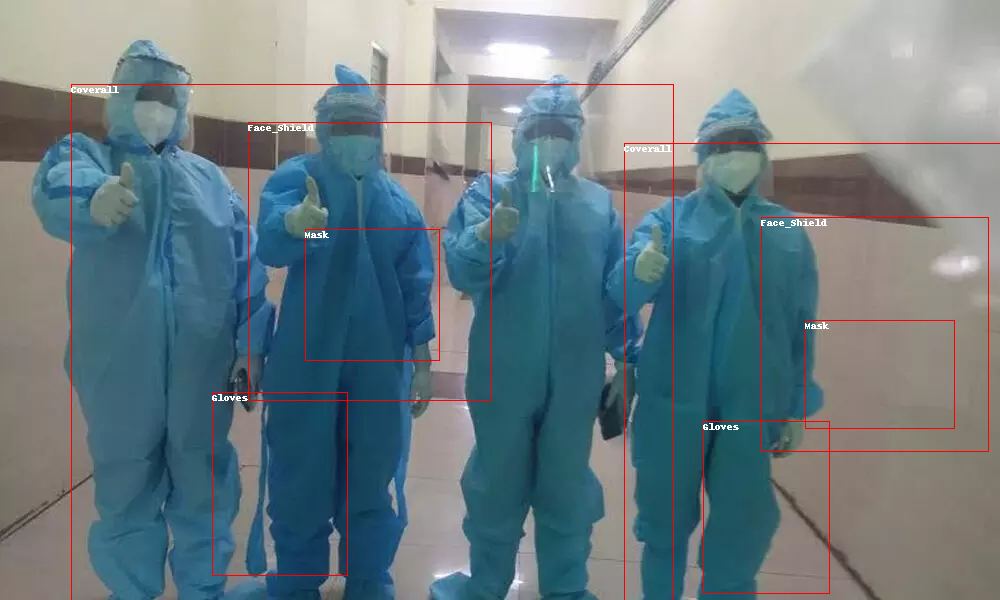

In [8]:
# Let us see whн we are having errors in bboxes of the above elements
image = dataset["train"][878]["image"]
annotations = dataset["train"][878]["objects"]
draw = ImageDraw.Draw(image)

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

In [9]:
# Okay, these are all bad annotations, so we remove it from the tarin set
# + I found more annotation errors from HF hub
keep = [i for i in range(len(dataset["train"])) if i not in ids_to_remove+[821, 875, 876, 879]]
dataset["train"] = dataset["train"].select(keep)

In [10]:
ids_to_remove_test = []
for idx, element in enumerate(dataset['test']):
    width, height = element['image'].size
    element['width'], element['height'] = width, height 
    for bbox in element['objects']['bbox']:
        x_min, y_min, box_width, box_height = bbox
        x_max = x_min + box_width
        y_max = y_min + box_height

        x_min, x_max = x_min / width, x_max / width
        y_min, y_max = y_min / height, y_max / height
        bbox_new = (x_min, y_min, x_max, y_max)
        for val in bbox_new:
            if not 0 <= val <= 1 and not np.isclose(val, 0) and not np.isclose(val, 1):
                ids_to_remove_test.append(idx)

keep_test = [i for i in range(len(dataset["test"])) if i not in ids_to_remove_test]
dataset["test"] = dataset["test"].select(keep_test)

In [11]:
train_loader = DataLoader(dataset['train'], batch_size=16, shuffle=True, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(dataset['test'], batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)

img_tr, trg_tr = next(iter(train_loader))

## Model

Let us start be defining the backbone (simple ResNet) and the RPN class which consists of an acnhor generator and a head.

For **backbone** we can use either ResNet with FRN or just ResNet. The FPN backbone uses layers 1 to 4 of Resnet and adds a FeaturePyramidNetwork on top of it. Implementation is based on Feature Pyramid Network for Object Detection from the [paper](https://arxiv.org/abs/1612.03144). Feature Pyramid Network is a technique for combining features from different levels of a CNN to improve the performance of object detection

The **RPN** divides the input image into a grid of squares, or anchors. It then extracts features from each anchor and  uses those features to classify the anchor as containing an object or not containing an object

An **anchor generator** is a module in an object detection model that generates anchor boxes. Anchor boxes are rectangular boxes that are placed at different locations and scales on an image. The object detection model then predicts whether each anchor box contains an object and, if so, the class and bounding box of the object.

RPN typically does some post-processing after generating the candidate object regions and their classification and regression predictions. One common post-processing step is called non-maximum suppression (NMS).

**NMS** is a technique that is used to remove duplicate object detections. NMS works by iterating over the candidate object regions and suppressing all regions that overlap significantly with a higher-scoring region.
After performing post-processing, the RPN outputs the top-scoring candidate object regions

In [12]:
import sys
import math
from tqdm import tqdm
import pandas as pd
from typing import List, Tuple

from torch import Tensor
from torchvision.models.detection.rpn import RegionProposalNetwork, RPNHead, AnchorGenerator
from torchvision.models.detection.faster_rcnn import MultiScaleRoIAlign, TwoMLPHead, FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# backbone = models.wide_resnet50_2(pretrained=True)
# backbone = torch.nn.Sequential(*(list(backbone.children())[:-2]))
backbone = resnet_fpn_backbone('resnet50', pretrained=True, trainable_layers=0)

In [13]:
# let's make the RPN generate 5 x 3 anchors per spatial location, with 5 different sizes and 3 different aspect ratios.
# We define 5 tuples for size and ratio, because the backbone returns 5 feature maps

anchor_generator = AnchorGenerator(
     sizes= ((16,), (32,), (64,), (128,), (256,), (512,)),
     aspect_ratios=tuple([(0.25, 0.5, 1.0, 2.0) for _ in range(5)])
     )

rpn_pre_nms_top_n = dict(training=2000, testing=1000)
rpn_post_nms_top_n = dict(training=2000, testing=1000)
out_channels = backbone.out_channels = 256

rpn_head = RPNHead(out_channels, anchor_generator.num_anchors_per_location()[0])

my_rpn = RegionProposalNetwork(
    anchor_generator,
    rpn_head,
    fg_iou_thresh=0.7,
    bg_iou_thresh=0.3,
    batch_size_per_image=256,
    positive_fraction=0.5,
    pre_nms_top_n=rpn_pre_nms_top_n,
    post_nms_top_n=rpn_post_nms_top_n,
    nms_thresh=0.7,
    score_thresh=0.0,
)

In [14]:
class ImageList:
    def __init__(self, tensors: Tensor, image_sizes: List[Tuple[int, int]]) -> None:
        self.tensors = tensors
        self.image_sizes = image_sizes

    def to(self, device: torch.device) -> "ImageList":
        cast_tensor = self.tensors.to(device)
        return ImageList(cast_tensor, self.image_sizes)

In [16]:
# Let's define dummy two images
images = ImageList(torch.rand(2, 3, 264, 264), [(264, 264), (264, 264)])
features_resnet = backbone(images.tensors)
print(features_resnet.keys())

my_rpn.training = False # otherwise it will require targets to train
rpn_out = my_rpn(images, features_resnet)
proposals, losses = rpn_out

# Here we have proposals for each img in the batch, 654 proposals for img-1 and 653 for img-2
proposals[0].size(), proposals[1].size()

odict_keys(['0', '1', '2', '3', 'pool'])


(torch.Size([1000, 4]), torch.Size([1000, 4]))

The output proposals from RPN module are then passed to the RoI (Region of Interest) module. We will follow the same steps as in the torchvision package. Below are the components we wll be using:

- **RoI align** takes an ROI and a feature map as input and produces a new feature map of a fixed size. RoI align works by dividing the ROI into a grid of cells and then pooling the values of the feature map within each cell. It is useful because it ensures that all ROIs are resized to the same size before they are passed to the RoI head.

- The **RoI head** are just MLP layers which are standard heads for FPN-based models. The RoI head MLPs learn to extract features from ROIs that are useful for object detection tasks

- The **bbox_predictor** is a standard classification + bounding box regression layers for Fast R-CNN. Consists of two Linear layers, one for classification and one for box predcition. Takes as argument num_classes - number of classes fro detected objects + 1 for no_object class.

In [17]:
roi_align = MultiScaleRoIAlign(featmap_names=features_resnet.keys(), output_size=7, sampling_ratio=2)
resolution = roi_align.output_size[0]
representation_size = 1024 # hidden dim fro linear layers, which will be the output dim at the end
roi_head = TwoMLPHead(out_channels * resolution**2, representation_size)
bbox_predictor = FastRCNNPredictor(representation_size, num_classes=20)

In [18]:
# This gives us the sum of all box proposals from RPN (1000 + 1000)
# For each proposed box we have obtained pooled features (in channel x output_size x output_size) shape
pooled_boxes = roi_align(x=features_resnet, boxes=proposals, image_shapes=images.image_sizes)
print(pooled_boxes.size())

box_features = roi_head(pooled_boxes)
print(box_features.size())

class_logits, box_regression = bbox_predictor(box_features)
print(class_logits.size(), box_regression.size())

torch.Size([2000, 256, 7, 7])
torch.Size([2000, 1024])
torch.Size([2000, 20]) torch.Size([2000, 80])


### Put all the pieces together in one model


In [19]:
# Put all the pieces together in one model
def get_resnet50_rcnn(backbone, anchor_generator, roi_pooler, num_classes):
    model = FasterRCNN(backbone, num_classes=num_classes,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler)
    return model

fast_rcnn = get_resnet50_rcnn(backbone, anchor_generator, roi_align, len(categories)+1)

In [18]:
# Also, we can get the pretrained model and finetune it for better performance
fast_rcnn = models.detection.fasterrcnn_resnet50_fpn(
    pretrained=True, progress=True, pretrained_backbone=True)

num_classes = len(categories) + 1
in_features = fast_rcnn.roi_heads.box_predictor.cls_score.in_features
fast_rcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [21]:
# Check that it works using out first batch of img and trg from before
fast_rcnn(img_tr, trg_tr)

{'loss_classifier': tensor(2.2519, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.1208, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.6043, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.1385, grad_fn=<DivBackward0>)}

## Training the model

Now, as we already have the dataloader and the model defined, let us create a training loop.

To train a Faster R-CNN model, we need to provide it with a dataset of images and their corresponding annotations. The annotations should specify the class and bounding box of each object in the image.

Once we have a dataset, we can start training the model by feeding it batches of images and annotations. The model will then learn to generate candidate object regions using the RPN, and then classify and regress the candidate object regions using the Fast R-CNN detector.

During training, we use a loss function to measure how well the model is performing. The loss function is calculated by comparing the model's predictions to the ground truth annotations. The model is then updated using an optimizer to minimize the loss function.

Some common optimizers used for training Faster R-CNN models include:

- Stochastic gradient descent (SGD)
- Adam/AdamW
- RMSprop

We can also use a learning rate scheduler to adjust the learning rate during training. The learning rate scheduler typically reduces the learning rate over time, which helps to improve the convergence of the model.

The following code shows a simple example of how to train a Faster R-CNN model in PyTorch:

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
params = [p for p in fast_rcnn.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=2e-5)

grad_accum_steps = 4
num_train_epochs = 20
total_iters = len(train_loader) // grad_accum_steps * num_train_epochs
scheduler = transformers.get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=50, num_training_steps=total_iters
)

#if torch.cuda.device_count() > 1:
#    fast_rcnn = nn.DataParallel(fast_rcnn)
fast_rcnn.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [21]:
def train_one_epoch(model, optimizer, loader, test_loader, device, epoch, num_train_epochs):
    model.train()
    all_losses, all_losses_dict = [], []
    all_losses_test, all_losses_dict_test = [], []

    for i, (images, targets) in enumerate(tqdm(loader, desc=f"Epoch {epoch+1}/{num_train_epochs}",
                            unit="batch", total=len(loader))):
        images = [img.to(device) for img in images]
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig")
            print(loss_dict)
            sys.exit(1)

        losses.backward()
        if (i + 1) % grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

    all_losses_dict = pd.DataFrame(all_losses_dict)
    print("\nTrain lr: {:.6f}, loss: {:.3f}, loss_classifier: {:.3f}, loss_box: {:.3f}, loss_rpn_box: {:.3f}, loss_object: {:.3f}".format(
        optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))
    
    del images, targets, losses, all_losses_dict
    torch.cuda.empty_cache()

    for i, (images, targets) in enumerate(test_loader):
        images = [img.to(device) for img in images]
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_test = {k: v.item() for k, v in loss_dict.items()}
        loss_value_test = losses.item()

        all_losses_test.append(loss_value_test)
        all_losses_dict_test.append(loss_dict_test)

    all_losses_dict_test = pd.DataFrame(all_losses_dict_test)
    print("Test loss: {:.3f}, loss_classifier: {:.3f}, loss_box: {:.3f}, loss_rpn_box: {:.3f}, loss_object: {:.3f}".format(
        np.mean(all_losses_test),
        all_losses_dict_test['loss_classifier'].mean(),
        all_losses_dict_test['loss_box_reg'].mean(),
        all_losses_dict_test['loss_rpn_box_reg'].mean(),
        all_losses_dict_test['loss_objectness'].mean()
    ))

In [22]:
fast_rcnn.train()
for epoch in range(num_train_epochs):
    train_one_epoch(fast_rcnn, optimizer, train_loader, test_loader, device, epoch, num_train_epochs)

Epoch 1/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:30<00:00,  1.44s/batch]




Train lr: 0.000006, loss: 1.858, loss_classifier: 1.435, loss_box: 0.100, loss_rpn_box: 0.039, loss_object: 0.283
Test loss: 1.402, loss_classifier: 0.878, loss_box: 0.260, loss_rpn_box: 0.052, loss_object: 0.213


Epoch 2/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:39<00:00,  1.57s/batch]




Train lr: 0.000012, loss: 0.802, loss_classifier: 0.440, loss_box: 0.180, loss_rpn_box: 0.035, loss_object: 0.146
Test loss: 1.021, loss_classifier: 0.485, loss_box: 0.302, loss_rpn_box: 0.052, loss_object: 0.182


Epoch 3/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:39<00:00,  1.57s/batch]




Train lr: 0.000018, loss: 0.682, loss_classifier: 0.326, loss_box: 0.216, loss_rpn_box: 0.033, loss_object: 0.107
Test loss: 0.941, loss_classifier: 0.457, loss_box: 0.338, loss_rpn_box: 0.042, loss_object: 0.104


Epoch 4/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:38<00:00,  1.57s/batch]




Train lr: 0.000019, loss: 0.628, loss_classifier: 0.294, loss_box: 0.222, loss_rpn_box: 0.029, loss_object: 0.083
Test loss: 0.996, loss_classifier: 0.456, loss_box: 0.402, loss_rpn_box: 0.046, loss_object: 0.092


Epoch 5/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:39<00:00,  1.58s/batch]




Train lr: 0.000018, loss: 0.626, loss_classifier: 0.289, loss_box: 0.244, loss_rpn_box: 0.027, loss_object: 0.067
Test loss: 0.955, loss_classifier: 0.438, loss_box: 0.405, loss_rpn_box: 0.041, loss_object: 0.071


Epoch 6/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:39<00:00,  1.58s/batch]




Train lr: 0.000017, loss: 0.626, loss_classifier: 0.285, loss_box: 0.254, loss_rpn_box: 0.026, loss_object: 0.061
Test loss: 0.953, loss_classifier: 0.429, loss_box: 0.417, loss_rpn_box: 0.037, loss_object: 0.070


Epoch 7/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:39<00:00,  1.58s/batch]




Train lr: 0.000016, loss: 0.603, loss_classifier: 0.272, loss_box: 0.248, loss_rpn_box: 0.026, loss_object: 0.058
Test loss: 0.861, loss_classifier: 0.382, loss_box: 0.360, loss_rpn_box: 0.042, loss_object: 0.077


Epoch 8/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:39<00:00,  1.59s/batch]




Train lr: 0.000014, loss: 0.578, loss_classifier: 0.259, loss_box: 0.242, loss_rpn_box: 0.024, loss_object: 0.053
Test loss: 0.853, loss_classifier: 0.376, loss_box: 0.373, loss_rpn_box: 0.038, loss_object: 0.065


Epoch 9/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:39<00:00,  1.58s/batch]




Train lr: 0.000013, loss: 0.561, loss_classifier: 0.251, loss_box: 0.239, loss_rpn_box: 0.024, loss_object: 0.048
Test loss: 0.827, loss_classifier: 0.358, loss_box: 0.370, loss_rpn_box: 0.038, loss_object: 0.061


Epoch 10/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:39<00:00,  1.58s/batch]




Train lr: 0.000012, loss: 0.536, loss_classifier: 0.236, loss_box: 0.231, loss_rpn_box: 0.023, loss_object: 0.046
Test loss: 0.800, loss_classifier: 0.338, loss_box: 0.361, loss_rpn_box: 0.034, loss_object: 0.067


Epoch 11/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:41<00:00,  1.61s/batch]




Train lr: 0.000011, loss: 0.516, loss_classifier: 0.226, loss_box: 0.225, loss_rpn_box: 0.023, loss_object: 0.042
Test loss: 0.788, loss_classifier: 0.331, loss_box: 0.355, loss_rpn_box: 0.036, loss_object: 0.066


Epoch 12/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:39<00:00,  1.57s/batch]




Train lr: 0.000010, loss: 0.509, loss_classifier: 0.219, loss_box: 0.225, loss_rpn_box: 0.023, loss_object: 0.042
Test loss: 0.755, loss_classifier: 0.317, loss_box: 0.349, loss_rpn_box: 0.035, loss_object: 0.054


Epoch 13/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:39<00:00,  1.58s/batch]




Train lr: 0.000008, loss: 0.495, loss_classifier: 0.212, loss_box: 0.223, loss_rpn_box: 0.022, loss_object: 0.038
Test loss: 0.739, loss_classifier: 0.300, loss_box: 0.339, loss_rpn_box: 0.034, loss_object: 0.066


Epoch 14/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:39<00:00,  1.58s/batch]




Train lr: 0.000007, loss: 0.487, loss_classifier: 0.207, loss_box: 0.220, loss_rpn_box: 0.022, loss_object: 0.038
Test loss: 0.735, loss_classifier: 0.295, loss_box: 0.343, loss_rpn_box: 0.036, loss_object: 0.061


Epoch 15/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:39<00:00,  1.57s/batch]




Train lr: 0.000006, loss: 0.480, loss_classifier: 0.201, loss_box: 0.222, loss_rpn_box: 0.022, loss_object: 0.035
Test loss: 0.723, loss_classifier: 0.302, loss_box: 0.343, loss_rpn_box: 0.034, loss_object: 0.044


Epoch 16/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:38<00:00,  1.57s/batch]




Train lr: 0.000005, loss: 0.470, loss_classifier: 0.195, loss_box: 0.218, loss_rpn_box: 0.021, loss_object: 0.035
Test loss: 0.707, loss_classifier: 0.280, loss_box: 0.331, loss_rpn_box: 0.035, loss_object: 0.061


Epoch 17/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:39<00:00,  1.58s/batch]




Train lr: 0.000004, loss: 0.468, loss_classifier: 0.194, loss_box: 0.216, loss_rpn_box: 0.022, loss_object: 0.036
Test loss: 0.701, loss_classifier: 0.281, loss_box: 0.328, loss_rpn_box: 0.034, loss_object: 0.059


Epoch 18/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:39<00:00,  1.58s/batch]




Train lr: 0.000002, loss: 0.464, loss_classifier: 0.192, loss_box: 0.217, loss_rpn_box: 0.021, loss_object: 0.033
Test loss: 0.692, loss_classifier: 0.275, loss_box: 0.328, loss_rpn_box: 0.032, loss_object: 0.056


Epoch 19/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:41<00:00,  1.62s/batch]



Train lr: 0.000001, loss: 0.455, loss_classifier: 0.187, loss_box: 0.214, loss_rpn_box: 0.021, loss_object: 0.033


Test loss: 0.690, loss_classifier: 0.273, loss_box: 0.327, loss_rpn_box: 0.033, loss_object: 0.057


Epoch 20/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:39<00:00,  1.58s/batch]




Train lr: 0.000000, loss: 0.467, loss_classifier: 0.192, loss_box: 0.221, loss_rpn_box: 0.021, loss_object: 0.032
Test loss: 0.720, loss_classifier: 0.290, loss_box: 0.324, loss_rpn_box: 0.037, loss_object: 0.071


In [23]:
#del fast_rcnn
torch.cuda.empty_cache()


Here are some advanced level tips for training Faster R-CNN models:

- Use a mixed precision training framework if out of memory. Mixed precision training allows you to train your model using a mixture of float32 and float16 data types. This can significantly reduce the memory footprint and training time of your model.
- Use a distributed training framework if you have multiple GPUs. Distributed training allows you to train your model on multiple GPUs or machines. This can further reduce the training time of your model.
- Use a warm-up scheduler. A warm-up scheduler gradually increases the learning rate from zero to a peak value over a period of time. This can help to improve the convergence of the model. We will be using linear scheduler here but feel free to experiment
- Use a larger dataset. The more data you have, the better your model will perform.
- Tune the hyperparameters. There are many hyperparameters that can affect the performance of your model, such as the learning rate, batch size, and number of epochs. It is important to tune these hyperparameters to find the best values for your model.
- Use a validation set for early stopping and parameter tuning. A validation set is a set of data that is used to evaluate the performance of your model during training. This will help you to track the progress of your model and identify any potential problems.

## Inference

Now we can chekc how our model performs on the test set. To perform inference with a Faster R-CNN model, you need to load the trained model and pass an image to the model's forward() method. The model will then output a list of detections, each of which contains the following information:

- label: The class of the object detected.
- score: The confidence score of the detection.
- bounding_box: The bounding box of the object detected.

In [24]:
fast_rcnn.eval()
torch.cuda.empty_cache()

In [26]:
img = dataset['test'][0]['image']
objs = dataset['test'][0]['objects']

transform_test = albumentations.Compose([
    albumentations.Resize(480, 480),
    albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    pytorch.ToTensorV2(),
], bbox_params=albumentations.BboxParams(format='coco', label_fields=['category']))


image = np.array(img.convert("RGB"))[:, :, ::-1]
out = transform_test(
    image=image,
    bboxes=objs['bbox'],
    category=objs['category']
)

img_tensor = out['image']
with torch.no_grad():
    prediction = fast_rcnn([img_tensor.to(device)])
    pred = prediction[0]

In [27]:
pred_classes = [id2label[i] for i in pred['labels'][pred['scores'] > 0.4].tolist()]
pred_boxes = pred['boxes'][pred['scores'] > 0.4]

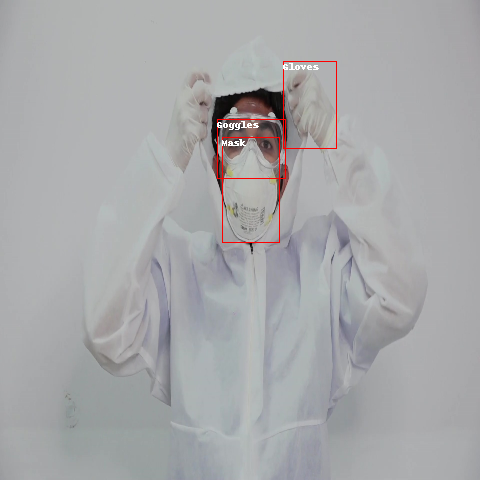

In [28]:
# The predictions seem to be reasonable but some boxes are not correct 100%
# For better accuracy, train a bit more, since I trained only 20 epochs just to see what happens

resize = albumentations.Resize(480, 480)
img_resized = resize(image=np.array(img.convert("RGB")))
draw_img = transforms.ToPILImage()(img_resized['image'])
draw = ImageDraw.Draw(draw_img)

for box, class_idx in zip(pred_boxes, pred_classes):
    x, y, x_max, y_max = tuple(box)
    draw.rectangle((x, y, x_max, y_max), outline="red", width=1)
    draw.text((x, y), class_idx, fill="white")

draw_img